# Visualization of the 1000-800 mb level on Urban Canyon IOP 1&2 Soundings

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc

In [41]:
def filter_data_every_10mb(data):
    unique_pressures = np.arange(800, 1001, 10)  # Define the range of pressure levels you are interested in
    filtered_data_list = []
    
    for level in unique_pressures:
        # Find all data points within the tolerance of 1 hPa
        within_tolerance = data[np.isclose(data['P'] % 10, level % 10, atol=1)]
        if not within_tolerance.empty:
            # Find the data point closest to the target pressure level
            closest = (np.abs(within_tolerance['P'] - level)).idxmin()
            filtered_data_list.append(within_tolerance.loc[closest])
    
    filtered_data = pd.DataFrame(filtered_data_list)
    return filtered_data

In [43]:
def read_gps_file(file_path):
    df = pd.read_csv(file_path, 
                     skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10],
                     sep=r'\s+', encoding='latin1')
    good_columns = df.columns[1:]
    df = df.drop(columns="HeightE")
    df.columns = good_columns
    p = df['P'].values * units.hPa
    z = df['HeightMSL'].values * units.m
    T = df['Temp'].values * units.degC
    Td = df['Dewp'].values * units.degC
    wind_speed = (df['Speed'].values * units('m/s').to('knots')
    wind_dir = df['Dir'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    df = pd.DataFrame({'P': p, 'T': T, 'TD': Td, 'u': u, 'v': v, 'z': z})
    return df.dropna()

def read_rts_file(file_path):
    df = pd.read_fwf(file_path, delimiter='\t', encoding='iso-8859-1')
    df = df.rename(columns={'Pressure[mbar]': 'P', 'T[°C] ': 'T', 'Dew [°C]': 'TD', 'Wsp [m/s]': 'wind_speed', 'Wdir [°]': 'wind_dir'})
    p = df['P'].values * units.hPa
    T = df['T'].values * units.degC
    Td = df['TD'].values * units.degC
    wind_speed = df['wind_speed'].values * units('m/s').to('knots')  # Convert to knots
    wind_dir = df['wind_dir'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    df = pd.DataFrame({'P': p, 'T': T, 'TD': Td, 'u': u, 'v': v})
    return df.dropna()

In [45]:
def determine_label(file_path):
    if 'GPS' in file_path:
        return 'Humboldt Park'
    elif 'Sonde1' in file_path:
        return 'Shedd Aquarium'
    elif 'Sonde3' in file_path:
        if '0727' in file_path or '0728' in file_path:
            return 'Woodlawn'
        else:
            return 'Gary Comer'
    return 'Unknown'

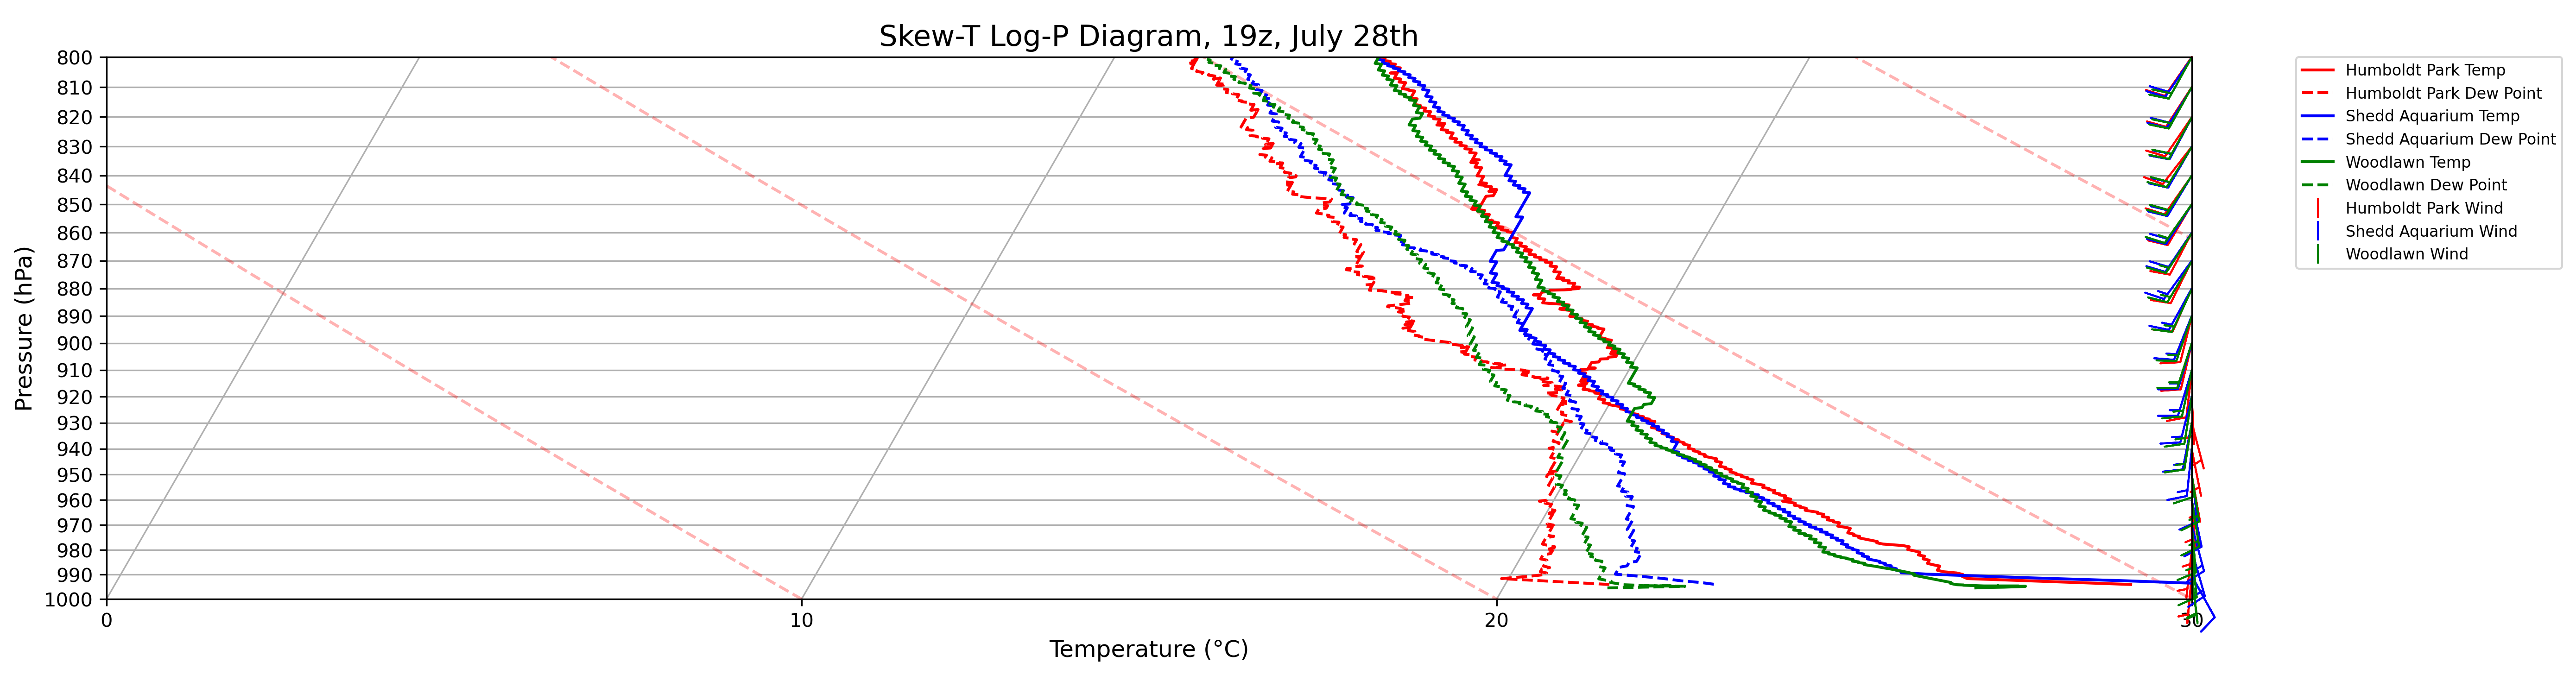

In [47]:
files = [
    ('20240728_1900_SHGPS.GPS', read_gps_file),
    ('20240728_1900_Sonde1_RTS.txt', read_rts_file),
    ('20240728_1900_Sonde3_RTS.txt', read_rts_file)
]

data_dict = {file: func(file) for file, func in files}

# Filter data to include only the closest point to each pressure level at intervals of 10 mb
filtered_data_dict = {file: filter_data_every_10mb(data) for file, data in data_dict.items()}

# Create a new figure with a significantly increased height
fig = plt.figure(figsize=(5, 50), dpi=300)  # Adjusting the height to make the figure taller
rect = [-1, -1, 3, 1000]  # Adjust rect parameter accordingly
skew = SkewT(fig, rect=rect)

colors = {'Humboldt Park': 'r', 'Shedd Aquarium': 'b', 'Woodlawn': 'g', 'Gary Comer': 'g'}
for file, data in data_dict.items():
    label = determine_label(file)
    color = colors.get(label, 'k')
    skew.plot(data['P'], data['T'], color, label=f'{label} Temp')
    skew.plot(data['P'], data['TD'], f'{color}--', label=f'{label} Dew Point')
    
    filtered_data = filtered_data_dict[file]
    skew.plot_barbs(filtered_data['P'], filtered_data['u'], filtered_data['v'], color=color)

# Create custom legend
handles, labels = skew.ax.get_legend_handles_labels()
for file, data in data_dict.items():
    label = determine_label(file)
    color = colors.get(label, 'k')
    handles.append(plt.Line2D([0], [0], color=color, marker='|', linestyle='None', markersize=10, label=f'{label} Wind'))

skew.ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=8)
skew.plot_dry_adiabats(alpha=.3)

# Set the limits for zooming and custom y-axis ticks
skew.ax.set_xlim(0, 30)  # Temperature range from 0 to 30°C
skew.ax.set_ylim(1000, 800)  # Pressure range from 1000 to 900 hPa
skew.ax.set_yticks(np.arange(800, 1001, 10))  # Pressure levels at 5 hPa intervals

# Add gridlines, title, and labels
skew.ax.grid(True)
skew.ax.set_title('Skew-T Log-P Diagram, 19z, July 28th', fontsize=15)
skew.ax.set_xlabel('Temperature (°C)', fontsize=12)
skew.ax.set_ylabel('Pressure (hPa)', fontsize=12)

# Save and display the plot
plt.savefig('skewt_trend_19z28th.png', bbox_inches='tight', dpi=300)
plt.show()